# Method 3 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

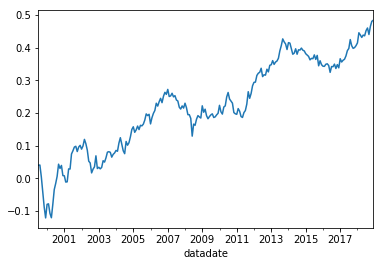

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31   -0.121593
2000-12-31    0.147758
2001-12-31    0.091960
2002-12-31   -0.064581
2003-12-31    0.046451
2004-12-31    0.066816
2005-12-31    0.040431
2006-12-31    0.051097
2007-12-31   -0.033474
2008-12-31   -0.025169
2009-12-31    0.012205
2010-12-31   -0.001193
2011-12-31    0.071805
2012-12-31    0.048899
2013-12-31    0.035854
2014-12-31   -0.003098
2015-12-31   -0.030282
2016-12-31   -0.007192
2017-12-31    0.050744
2018-12-31    0.055435
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     7.871
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.83e-06
Time:                        13:09:51   Log-Likelihood:                 656.00
No. Observations:                 234   AIC:                            -1302.
Df Residuals:                     229   BIC:                            -1285.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.942      0.004       0.001       0.005
mktrf         -0.1114      0.028     -4.029      0.000      -0.166      -0.057
me            -0.0040      0.032     -0.125      0.901      -0.067       0.059
ia             0.0516      0.049      1.056      0.292      -0.045       0.148
roe           -0.2209      0.042     -5.280      0.000      -0.303      -0.138
==============================================================================
Omnibus:                        9.738   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.661
Skew:                          -0.190   Prob(JB):                     0.000241
Kurtosis:                       4.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     6.740
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.82e-05
Time:                        13:09:51   Log-Likelihood:                 656.00
No. Observations:                 234   AIC:                            -1302.
Df Residuals:                     229   BIC:                            -1285.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.770      0.006       0.001       0.005
mktrf         -0.1114      0.031     -3.540      0.000      -0.173      -0.050
me            -0.0040      0.024     -0.167      0.867      -0.051       0.043
ia             0.0516      0.075      0.691      0.490      -0.095       0.198
roe           -0.2209      0.060     -3.709      0.000      -0.338      -0.104
==============================================================================
Omnibus:                        9.738   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.661
Skew:                          -0.190   Prob(JB):                     0.000241
Kurtosis:                       4.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     9.898
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-07
Time:                        13:09:51   Log-Likelihood:                 656.00
No. Observations:                 234   AIC:                            -1302.
Df Residuals:                     229   BIC:                            -1285.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.859      0.004       0.001       0.005
mktrf         -0.1114      0.030     -3.658      0.000      -0.171      -0.052
me            -0.0040      0.023     -0.172      0.863      -0.050       0.042
ia             0.0516      0.076      0.677      0.498      -0.098       0.201
roe           -0.2209      0.054     -4.068      0.000      -0.327      -0.114
==============================================================================
Omnibus:                        9.738   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.661
Skew:                          -0.190   Prob(JB):                     0.000241
Kurtosis:                       4.251   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.383
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00573
Time:                        13:09:51   Log-Likelihood:                 649.30
No. Observations:                 234   AIC:                            -1287.
Df Residuals:                     228   BIC:                            -1266.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.557      0.011       0.001       0.005
mktrf         -0.0758      0.029     -2.653      0.009      -0.132      -0.019
smb           -0.0228      0.038     -0.606      0.545      -0.097       0.051
hml            0.0301      0.044      0.677      0.499      -0.057       0.118
rmw           -0.1814      0.050     -3.609      0.000      -0.280      -0.082
cma            0.0546      0.064      0.854      0.394      -0.071       0.180
==============================================================================
Omnibus:                       10.517   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               21.850
Skew:                          -0.087   Prob(JB):                     1.80e-05
Kurtosis:                       4.487   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     7.557
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.38e-06
Time:                        13:09:51   Log-Likelihood:                 649.30
No. Observations:                 234   AIC:                            -1287.
Df Residuals:                     228   BIC:                            -1266.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.477      0.013       0.001       0.005
mktrf         -0.0758      0.026     -2.900      0.004      -0.127      -0.025
smb           -0.0228      0.036     -0.629      0.529      -0.094       0.048
hml            0.0301      0.045      0.674      0.501      -0.057       0.118
rmw           -0.1814      0.053     -3.413      0.001      -0.286      -0.077
cma            0.0546      0.064      0.846      0.398      -0.072       0.181
==============================================================================
Omnibus:                       10.517   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               21.850
Skew:                          -0.087   Prob(JB):                     1.80e-05
Kurtosis:                       4.487   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     9.475
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.18e-08
Time:                        13:09:51   Log-Likelihood:                 649.30
No. Observations:                 234   AIC:                            -1287.
Df Residuals:                     228   BIC:                            -1266.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.665      0.008       0.001       0.005
mktrf         -0.0758      0.027     -2.795      0.005      -0.129      -0.023
smb           -0.0228      0.036     -0.638      0.523      -0.093       0.047
hml            0.0301      0.039      0.768      0.443      -0.047       0.107
rmw           -0.1814      0.053     -3.433      0.001      -0.285      -0.078
cma            0.0546      0.060      0.909      0.363      -0.063       0.172
==============================================================================
Omnibus:                       10.517   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               21.850
Skew:                          -0.087   Prob(JB):                     1.80e-05
Kurtosis:                       4.487   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     4.623
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00131
Time:                        13:09:51   Log-Likelihood:                 650.01
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.327      0.021       0.000       0.004
mktrf         -0.0765      0.026     -2.929      0.004      -0.128      -0.025
smb            0.0736      0.033      2.258      0.025       0.009       0.138
hml           -0.0201      0.032     -0.622      0.535      -0.084       0.044
umd           -0.0829      0.021     -3.900      0.000      -0.125      -0.041
==============================================================================
Omnibus:                        6.882   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               11.038
Skew:                          -0.073   Prob(JB):                      0.00401
Kurtosis:                       4.054   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     3.579
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00746
Time:                        13:09:51   Log-Likelihood:                 650.01
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.445      0.015       0.000       0.004
mktrf         -0.0765      0.034     -2.281      0.023      -0.142      -0.011
smb            0.0736      0.044      1.671      0.095      -0.013       0.160
hml           -0.0201      0.030     -0.673      0.501      -0.079       0.039
umd           -0.0829      0.035     -2.336      0.019      -0.152      -0.013
==============================================================================
Omnibus:                        6.882   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               11.038
Skew:                          -0.073   Prob(JB):                      0.00401
Kurtosis:                       4.054   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5.161
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000535
Time:                        13:09:51   Log-Likelihood:                 650.01
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.420      0.016       0.000       0.004
mktrf         -0.0765      0.033     -2.294      0.022      -0.142      -0.011
smb            0.0736      0.045      1.653      0.098      -0.014       0.161
hml           -0.0201      0.027     -0.759      0.448      -0.072       0.032
umd           -0.0829      0.029     -2.827      0.005      -0.140      -0.025
==============================================================================
Omnibus:                        6.882   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               11.038
Skew:                          -0.073   Prob(JB):                      0.00401
Kurtosis:                       4.054   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     5.537
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000411
Time:                        13:09:51   Log-Likelihood:                 314.18
No. Observations:                 120   AIC:                            -618.4
Df Residuals:                     115   BIC:                            -604.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.491      0.139      -0.001       0.006
mktrf         -0.1382      0.046     -2.973      0.004      -0.230      -0.046
me            -0.0197      0.046     -0.429      0.669      -0.111       0.071
ia             0.1269      0.072      1.766      0.080      -0.015       0.269
roe           -0.2860      0.064     -4.496      0.000      -0.412      -0.160
==============================================================================
Omnibus:                        2.510   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.364
Skew:                          -0.013   Prob(JB):                        0.307
Kurtosis:                       3.687   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     5.137
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000762
Time:                        13:09:51   Log-Likelihood:                 314.18
No. Observations:                 120   AIC:                            -618.4
Df Residuals:                     115   BIC:                            -604.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.448      0.148      -0.001       0.006
mktrf         -0.1382      0.051     -2.722      0.006      -0.238      -0.039
me            -0.0197      0.023     -0.852      0.394      -0.065       0.026
ia             0.1269      0.102      1.245      0.213      -0.073       0.327
roe           -0.2860      0.081     -3.514      0.000      -0.446      -0.126
==============================================================================
Omnibus:                        2.510   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.364
Skew:                          -0.013   Prob(JB):                        0.307
Kurtosis:                       3.687   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     9.444
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-06
Time:                        13:09:51   Log-Likelihood:                 314.18
No. Observations:                 120   AIC:                            -618.4
Df Residuals:                     115   BIC:                            -604.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.465      0.143      -0.001       0.006
mktrf         -0.1382      0.048     -2.893      0.004      -0.232      -0.045
me            -0.0197      0.020     -0.979      0.328      -0.059       0.020
ia             0.1269      0.100      1.269      0.204      -0.069       0.323
roe           -0.2860      0.070     -4.066      0.000      -0.424      -0.148
==============================================================================
Omnibus:                        2.510   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.364
Skew:                          -0.013   Prob(JB):                        0.307
Kurtosis:                       3.687   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.174
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0618
Time:                        13:09:51   Log-Likelihood:                 309.08
No. Observations:                 120   AIC:                            -606.2
Df Residuals:                     114   BIC:                            -589.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.351      0.179      -0.001       0.006
mktrf         -0.0842      0.051     -1.641      0.104      -0.186       0.017
smb           -0.0476      0.058     -0.818      0.415      -0.163       0.068
hml            0.0698      0.071      0.980      0.329      -0.071       0.211
rmw           -0.2359      0.084     -2.807      0.006      -0.402      -0.069
cma            0.0937      0.092      1.018      0.311      -0.089       0.276
==============================================================================
Omnibus:                        3.162   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                3.275
Skew:                           0.085   Prob(JB):                        0.194
Kurtosis:                       3.791   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     5.346
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000188
Time:                        13:09:51   Log-Likelihood:                 309.08
No. Observations:                 120   AIC:                            -606.2
Df Residuals:                     114   BIC:                            -589.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.380      0.167      -0.001       0.006
mktrf         -0.0842      0.044     -1.908      0.056      -0.171       0.002
smb           -0.0476      0.049     -0.979      0.328      -0.143       0.048
hml            0.0698      0.073      0.960      0.337      -0.073       0.212
rmw           -0.2359      0.083     -2.828      0.005      -0.399      -0.072
cma            0.0937      0.074      1.273      0.203      -0.051       0.238
==============================================================================
Omnibus:                        3.162   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                3.275
Skew:                           0.085   Prob(JB):                        0.194
Kurtosis:                       3.791   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     7.422
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.65e-06
Time:                        13:09:51   Log-Likelihood:                 309.08
No. Observations:                 120   AIC:                            -606.2
Df Residuals:                     114   BIC:                            -589.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.527      0.127      -0.001       0.006
mktrf         -0.0842      0.046     -1.831      0.067      -0.174       0.006
smb           -0.0476      0.048     -1.000      0.317      -0.141       0.046
hml            0.0698      0.066      1.066      0.287      -0.059       0.198
rmw           -0.2359      0.083     -2.842      0.004      -0.399      -0.073
cma            0.0937      0.069      1.359      0.174      -0.041       0.229
==============================================================================
Omnibus:                        3.162   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                3.275
Skew:                           0.085   Prob(JB):                        0.194
Kurtosis:                       3.791   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.685
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00733
Time:                        13:09:51   Log-Likelihood:                 310.85
No. Observations:                 120   AIC:                            -611.7
Df Residuals:                     115   BIC:                            -597.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.923      0.358      -0.002       0.005
mktrf         -0.0937      0.042     -2.227      0.028      -0.177      -0.010
smb            0.1016      0.048      2.120      0.036       0.007       0.197
hml            0.0001      0.048      0.002      0.998      -0.095       0.095
umd           -0.1083      0.030     -3.661      0.000      -0.167      -0.050
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.138
Skew:                          -0.004   Prob(JB):                        0.566
Kurtosis:                       3.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.802
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0291
Time:                        13:09:51   Log-Likelihood:                 310.85
No. Observations:                 120   AIC:                            -611.7
Df Residuals:                     115   BIC:                            -597.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.978      0.328      -0.002       0.005
mktrf         -0.0937      0.050     -1.881      0.060      -0.191       0.004
smb            0.1016      0.060      1.683      0.092      -0.017       0.220
hml            0.0001      0.040      0.003      0.998      -0.077       0.078
umd           -0.1083      0.046     -2.364      0.018      -0.198      -0.019
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.138
Skew:                          -0.004   Prob(JB):                        0.566
Kurtosis:                       3.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.153
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00353
Time:                        13:09:51   Log-Likelihood:                 310.85
No. Observations:                 120   AIC:                            -611.7
Df Residuals:                     115   BIC:                            -597.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.979      0.328      -0.002       0.005
mktrf         -0.0937      0.047     -1.996      0.046      -0.186      -0.002
smb            0.1016      0.060      1.691      0.091      -0.016       0.219
hml            0.0001      0.033      0.003      0.997      -0.064       0.064
umd           -0.1083      0.038     -2.886      0.004      -0.182      -0.035
==============================================================================
Omnibus:                        1.568   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.138
Skew:                          -0.004   Prob(JB):                        0.566
Kurtosis:                       3.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.516
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00969
Time:                        13:09:51   Log-Likelihood:                 364.19
No. Observations:                 114   AIC:                            -718.4
Df Residuals:                     109   BIC:                            -704.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.166      0.002       0.001       0.005
mktrf         -0.0909      0.030     -3.049      0.003      -0.150      -0.032
me             0.0366      0.046      0.795      0.428      -0.055       0.128
ia            -0.1106      0.064     -1.732      0.086      -0.237       0.016
roe           -0.1234      0.056     -2.199      0.030      -0.235      -0.012
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.240
Skew:                          -0.153   Prob(JB):                        0.538
Kurtosis:                       2.592   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.660
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00775
Time:                        13:09:51   Log-Likelihood:                 364.19
No. Observations:                 114   AIC:                            -718.4
Df Residuals:                     109   BIC:                            -704.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.517      0.012       0.001       0.006
mktrf         -0.0909      0.031     -2.966      0.003      -0.151      -0.031
me             0.0366      0.046      0.803      0.422      -0.053       0.126
ia            -0.1106      0.064     -1.742      0.082      -0.235       0.014
roe           -0.1234      0.055     -2.229      0.026      -0.232      -0.015
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.240
Skew:                          -0.153   Prob(JB):                        0.538
Kurtosis:                       2.592   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6.609
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.43e-05
Time:                        13:09:51   Log-Likelihood:                 364.19
No. Observations:                 114   AIC:                            -718.4
Df Residuals:                     109   BIC:                            -704.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.437      0.015       0.001       0.006
mktrf         -0.0909      0.025     -3.595      0.000      -0.140      -0.041
me             0.0366      0.047      0.779      0.436      -0.055       0.129
ia            -0.1106      0.065     -1.701      0.089      -0.238       0.017
roe           -0.1234      0.060     -2.055      0.040      -0.241      -0.006
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.240
Skew:                          -0.153   Prob(JB):                        0.538
Kurtosis:                       2.592   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.489
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0356
Time:                        13:09:51   Log-Likelihood:                 363.48
No. Observations:                 114   AIC:                            -715.0
Df Residuals:                     108   BIC:                            -698.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.055      0.003       0.001       0.005
mktrf         -0.0786      0.029     -2.736      0.007      -0.136      -0.022
smb            0.0203      0.047      0.434      0.665      -0.072       0.113
hml           -0.0048      0.060     -0.080      0.936      -0.123       0.113
rmw           -0.1606      0.073     -2.204      0.030      -0.305      -0.016
cma           -0.0844      0.093     -0.912      0.364      -0.268       0.099
==============================================================================
Omnibus:                        0.780   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.824
Skew:                          -0.017   Prob(JB):                        0.662
Kurtosis:                       2.585   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.957
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00247
Time:                        13:09:51   Log-Likelihood:                 363.48
No. Observations:                 114   AIC:                            -715.0
Df Residuals:                     108   BIC:                            -698.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.603      0.009       0.001       0.005
mktrf         -0.0786      0.032     -2.483      0.013      -0.141      -0.017
smb            0.0203      0.045      0.453      0.650      -0.067       0.108
hml           -0.0048      0.056     -0.086      0.931      -0.114       0.104
rmw           -0.1606      0.057     -2.831      0.005      -0.272      -0.049
cma           -0.0844      0.085     -0.991      0.322      -0.251       0.083
==============================================================================
Omnibus:                        0.780   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.824
Skew:                          -0.017   Prob(JB):                        0.662
Kurtosis:                       2.585   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     6.254
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.92e-05
Time:                        13:09:51   Log-Likelihood:                 363.48
No. Observations:                 114   AIC:                            -715.0
Df Residuals:                     108   BIC:                            -698.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.538      0.011       0.001       0.006
mktrf         -0.0786      0.030     -2.653      0.008      -0.137      -0.021
smb            0.0203      0.044      0.460      0.646      -0.066       0.107
hml           -0.0048      0.043     -0.111      0.912      -0.089       0.080
rmw           -0.1606      0.054     -2.992      0.003      -0.266      -0.055
cma           -0.0844      0.061     -1.387      0.166      -0.204       0.035
==============================================================================
Omnibus:                        0.780   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.824
Skew:                          -0.017   Prob(JB):                        0.662
Kurtosis:                       2.585   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.473
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.215
Time:                        13:09:51   Log-Likelihood:                 360.27
No. Observations:                 114   AIC:                            -710.5
Df Residuals:                     109   BIC:                            -696.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.508      0.014       0.001       0.005
mktrf         -0.0617      0.029     -2.112      0.037      -0.120      -0.004
smb            0.0519      0.046      1.138      0.258      -0.038       0.142
hml           -0.0133      0.047     -0.283      0.778      -0.106       0.080
umd            0.0158      0.035      0.446      0.657      -0.054       0.086
==============================================================================
Omnibus:                        1.287   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.217
Skew:                          -0.118   Prob(JB):                        0.544
Kurtosis:                       2.552   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.504
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.206
Time:                        13:09:51   Log-Likelihood:                 360.27
No. Observations:                 114   AIC:                            -710.5
Df Residuals:                     109   BIC:                            -696.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.172      0.030       0.000       0.005
mktrf         -0.0617      0.029     -2.093      0.036      -0.120      -0.004
smb            0.0519      0.054      0.969      0.332      -0.053       0.157
hml           -0.0133      0.046     -0.288      0.773      -0.103       0.077
umd            0.0158      0.041      0.385      0.700      -0.064       0.096
==============================================================================
Omnibus:                        1.287   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.217
Skew:                          -0.118   Prob(JB):                        0.544
Kurtosis:                       2.552   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.149
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0171
Time:                        13:09:51   Log-Likelihood:                 360.27
No. Observations:                 114   AIC:                            -710.5
Df Residuals:                     109   BIC:                            -696.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.172      0.030       0.000       0.005
mktrf         -0.0617      0.027     -2.327      0.020      -0.114      -0.010
smb            0.0519      0.056      0.934      0.350      -0.057       0.161
hml           -0.0133      0.043     -0.309      0.757      -0.097       0.071
umd            0.0158      0.039      0.408      0.683      -0.060       0.092
==============================================================================
Omnibus:                        1.287   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.525   Jarque-Bera (JB):                1.217
Skew:                          -0.118   Prob(JB):                        0.544
Kurtosis:                       2.552   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""